In [1]:
from sklearn.cluster import KMeans
import numpy as np 
import pandas as pd 

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os


# Predicting machine failure with data from an air compressor on a MetroPT3 locomotive 

In [2]:
# Reading in MetroPT3 Air Compressor data
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', nrows=100000)
metro_df_large.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


Attribute Information:
The dataset consists of 15169480 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:
1. TP2 (bar) – the measure of the pressure on the compressor.
2. TP3 (bar) – the measure of the pressure generated at the pneumatic panel.
3. H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.
4. DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.
5. Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).
6. Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.
7. Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.
8. COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.
9. DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.
10. TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.
11. MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.
12. LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.
13. Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.
14. Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.
15. Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

Failure Information:

The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for evaluating the effectiveness of anomaly detection, failure prediction, and RUL estimation algorithms.

  Nr.     Start Time	          End Time	                 Failure	      Severity	         Report
* #1 	4/18/2020 0:00	   4/18/2020 23:59       Air leak	    High stress	
* #1 	5/29/2020 23:30     5/30/2020 6:00	    Air Leak	    High stress	Maintenance on 30Apr at 12:00
* #3 	6/5/2020 10:00	   6/7/2020 14:30	        Air Leak	    High stress	Maintenance on 8Jun at 16:00
* #4 	7/15/2020 14:30     7/15/2020 19:00      Air Leak	    High stress	Maintenance on 16Jul at 00:00

# Exploratory Data Analysis

In [3]:
# Summary statistics of the numeric features
metro_df_large.describe()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.0,100000.0
mean,499995.000000,0.570024,8.970174,8.373563,-0.015490,8.972447,57.114244,1.309649,0.935790,0.064230,0.96794,0.935790,0.000010,0.999190,1.0,1.0
std,288676.577967,2.257192,0.555464,2.257944,0.097673,0.554905,3.377109,1.991827,0.245128,0.245163,0.17616,0.245128,0.003162,0.028449,0.0,0.0
min,0.000000,-0.030000,7.324000,-0.030000,-0.028000,7.326000,31.975000,0.020000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.0,1.0
25%,249997.500000,-0.012000,8.494000,8.390000,-0.020000,8.496000,55.300000,0.035000,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.0,1.0
50%,499995.000000,-0.012000,8.948000,8.862000,-0.018000,8.950000,57.300000,0.037500,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.0,1.0
75%,749992.500000,-0.010000,9.424000,9.360000,-0.016000,9.426000,59.175000,3.717500,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,1.0,1.0
max,999990.000000,10.544000,10.164000,10.158000,6.530000,10.168000,69.150000,8.292500,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.0,1.0


In [4]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       100000 non-null  int64  
 1   timestamp        100000 non-null  object 
 2   TP2              100000 non-null  float64
 3   TP3              100000 non-null  float64
 4   H1               100000 non-null  float64
 5   DV_pressure      100000 non-null  float64
 6   Reservoirs       100000 non-null  float64
 7   Oil_temperature  100000 non-null  float64
 8   Motor_current    100000 non-null  float64
 9   COMP             100000 non-null  float64
 10  DV_eletric       100000 non-null  float64
 11  Towers           100000 non-null  float64
 12  MPG              100000 non-null  float64
 13  LPS              100000 non-null  float64
 14  Pressure_switch  100000 non-null  float64
 15  Oil_level        100000 non-null  float64
 16  Caudal_impulses  100000 non-null  float

In [5]:
# Every value of the Caudal_impulses and Oil_level columns is 1, 
# REQUIRES examination of full dataset before dropping these columns

print(metro_df_large.Caudal_impulses.value_counts())
print(metro_df_large.Oil_level.value_counts())

1.0    100000
Name: Caudal_impulses, dtype: int64
1.0    100000
Name: Oil_level, dtype: int64


# 

# Feature Extraction

The valuable information of the actual machinery failures needs to be transformed into a feature in the dataframe. Here I take steps to create failure_start, failure_end, and failure_duration features. I will use these to test the performance of the classification model.

In [6]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = ['04/18/2020 0:00', '05/29/2020 23:30',  '06/05/2020 10:00', '07/15/2020 14:30']
dt_fail_ends = ['04/18/2020 23:59', '05/30/2020 6:00', '06/07/2020 14:30', '07/15/2020 19:00']

failure_df = pd.DataFrame(list(zip(dt_fail_starts, dt_fail_ends)), columns=['failure_start','failure_end'], dtype='datetime64[ns]')

failure_df

,failure_start,failure_end
0,2020-04-18 00:00:00,2020-04-18 23:59:00
1,2020-05-29 23:30:00,2020-05-30 06:00:00
2,2020-06-05 10:00:00,2020-06-07 14:30:00
3,2020-07-15 14:30:00,2020-07-15 19:00:00


In [7]:
# Creating a fail_duration feature by subtracting datetime objects, returning a timedelta

failure_df['fail_duration'] = failure_df['failure_end'] - failure_df['failure_start'] 
failure_df.head()

,failure_start,failure_end,fail_duration
0,2020-04-18 00:00:00,2020-04-18 23:59:00,0 days 23:59:00
1,2020-05-29 23:30:00,2020-05-30 06:00:00,0 days 06:30:00
2,2020-06-05 10:00:00,2020-06-07 14:30:00,2 days 04:30:00
3,2020-07-15 14:30:00,2020-07-15 19:00:00,0 days 04:30:00


The BAR pressure value in the reservoirs ('Reservoirs') should be close to that measured at the pneumatic panel (TP3).
Next I create a dif_panel_reservoir feature by subtracting the value of 'Reservoirs' from the value of 'TP3' for each record.

In [8]:
# Creating a feature dif_panel_reservoir by subtracting Reservoirs value from TP3 value

metro_df_large['dif_panel_reservoir'] = abs(metro_df_large['TP3'] - metro_df_large['Reservoirs'])

metro_df_large['dif_panel_reservoir'].describe()

count    100000.000000
mean          0.002575
std           0.001933
min           0.000000
25%           0.002000
50%           0.002000
75%           0.004000
max           0.012000
Name: dif_panel_reservoir, dtype: float64

Creating a feature for the rolling average of the oil temperature.

In [9]:
metro_df_large['oil_rolling'] = metro_df_large['Oil_temperature'].rolling(6).mean()
metro_df_large.head(20)

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,dif_panel_reservoir,oil_rolling
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,NaN
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,NaN
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,NaN
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,NaN
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,NaN
5,50,2020-02-01 00:00:49,-0.012,9.306,9.290,-0.024,9.308,53.500,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.002,53.545833
6,60,2020-02-01 00:00:59,-0.012,9.296,9.280,-0.024,9.298,53.375,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.002,53.508333
7,70,2020-02-01 00:01:09,-0.014,9.286,9.270,-0.024,9.286,53.550,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,53.487500
8,80,2020-02-01 00:01:19,-0.012,9.276,9.258,-0.022,9.276,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,53.458333
9,90,2020-02-01 00:01:29,-0.012,9.264,9.248,-0.022,9.264,53.375,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000,53.450000


In [10]:
"""metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)
metro_df_clustering.info()"""

'metro_df_clustering = metro_df_large.drop(metro_df_large.columns[[0,1]], axis=1)\nmetro_df_clustering.info()'

In [11]:
"""# Set up KMeans
kmeans = KMeans(n_clusters=4, n_init=10)

# Fit the model to the data
kmeans.fit(metro_df_clustering)

# Predict the clusters
metro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"""

"# Set up KMeans\nkmeans = KMeans(n_clusters=4, n_init=10)\n\n# Fit the model to the data\nkmeans.fit(metro_df_clustering)\n\n# Predict the clusters\nmetro_df_large['cluster'] = kmeans.predict(metro_df_clustering)"

In [12]:
metro_df_large.head()

,Unnamed: 0,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,dif_panel_reservoir,oil_rolling
0,0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
1,10,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
2,20,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
3,30,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN
4,40,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,NaN


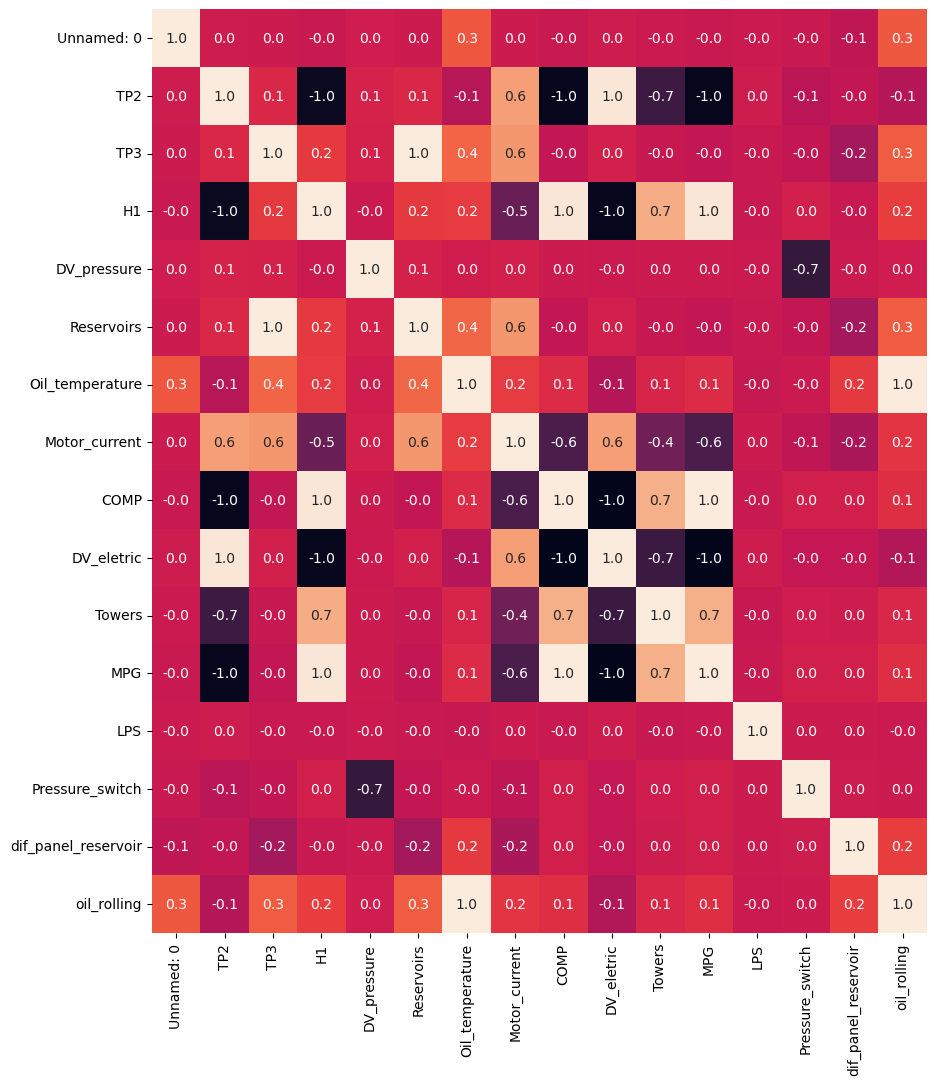

In [13]:
fig = plt.figure(figsize=(10,12))
hm = metro_df_large.drop(columns=['Oil_level','Caudal_impulses'], axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()

In [14]:
"""cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()
cluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()
cluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()
cluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()


cluster_0_df.head()"""


'cluster_0_df = metro_df_large[metro_df_large.cluster == 0].copy()\ncluster_1_df = metro_df_large[metro_df_large.cluster == 1].copy()\ncluster_2_df = metro_df_large[metro_df_large.cluster == 2].copy()\ncluster_3_df = metro_df_large[metro_df_large.cluster == 3].copy()\n\n\ncluster_0_df.head()'

In [15]:
#cluster_0_df.describe()

In [16]:
#cluster_1_df.describe()

In [17]:
#cluster_2_df.describe()

In [18]:
# Using the pandas dataframe correlation matrix to create a heatmap of pairwise correlations
"""fig = plt.figure(figsize=(10,12))
hm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)
sns.heatmap(hm, annot=True, fmt='.1f', cbar=False)
plt.show()"""

"fig = plt.figure(figsize=(10,12))\nhm = cluster_0_df.drop(columns=['Oil_level','Caudal_impulses','LPS'],axis=1).corr(numeric_only=True)\nsns.heatmap(hm, annot=True, fmt='.1f', cbar=False)\nplt.show()"

Feature extraction:
* rolling averages of features
* frequency of n percentile measurements (high stress / temp / motor current)
* 